In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/BERT

/content/drive/MyDrive/BERT


In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils import plot_model
from IPython.display import Image

In [2]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [3]:
# Read dataset & Preprocess text
# dataset = pd.read_csv('../input/isear-emotion/isear_dataset.csv')
df_train = pd.read_csv('./data/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('./data/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('./data/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [4]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [5]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [6]:
# Embedding
max_features = vocabSize
maxlen = X_train.shape[1]
embedding_size = 200

# Convolution
kernel_size = 5
filters = 128
pool_size = 4

# LSTM
lstm_output_size = 128

# Training
#batch_size = 30
#epochs = 2

In [7]:
print('Build model...')

model = Sequential()
model.add(Embedding(vocabSize, embedding_size, input_length=X_train.shape[1]))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 200)          3237000   
_________________________________________________________________
dropout (Dropout)            (None, 256, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 252, 128)          128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 63, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
activation (Activation)      (None, 6)   

In [8]:
adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
from keras.utils import plot_model
import pydot 
plot_model(model, to_file='model.png')


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
Image(retina=True, filename="model.png")

FileNotFoundError: [Errno 2] No such file or directory: 'model.png'

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 [==============================] - 18s 229ms/step - loss: 1.1722 - accuracy: 0.5594 - val_loss: 0.3865 - val_accuracy: 0.8590
Epoch 2/30
63/63 [==============================] - 12s 184ms/step - loss: 0.2367 - accuracy: 0.9141 - val_loss: 0.2127 - val_accuracy: 0.9180
Epoch 3/30
63/63 [==============================] - 9s 150ms/step - loss: 0.0908 - accuracy: 0.9639 - val_loss: 0.2677 - val_accuracy: 0.9040
Epoch 4/30
63/63 [==============================] - 5s 76ms/step - loss: 0.0508 - accuracy: 0.9801 - val_loss: 0.2896 - val_accuracy: 0.9055
Epoch 5/30
63/63 [==============================] - 6s 95ms/step - loss: 0.0302 - accuracy: 0.9890 - val_loss: 0.3078 - val_accuracy: 0.9035


In [ ]:
model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 1s 7ms/step - loss: 0.2016 - accuracy: 0.9085


[0.20163583755493164, 0.9085000157356262]

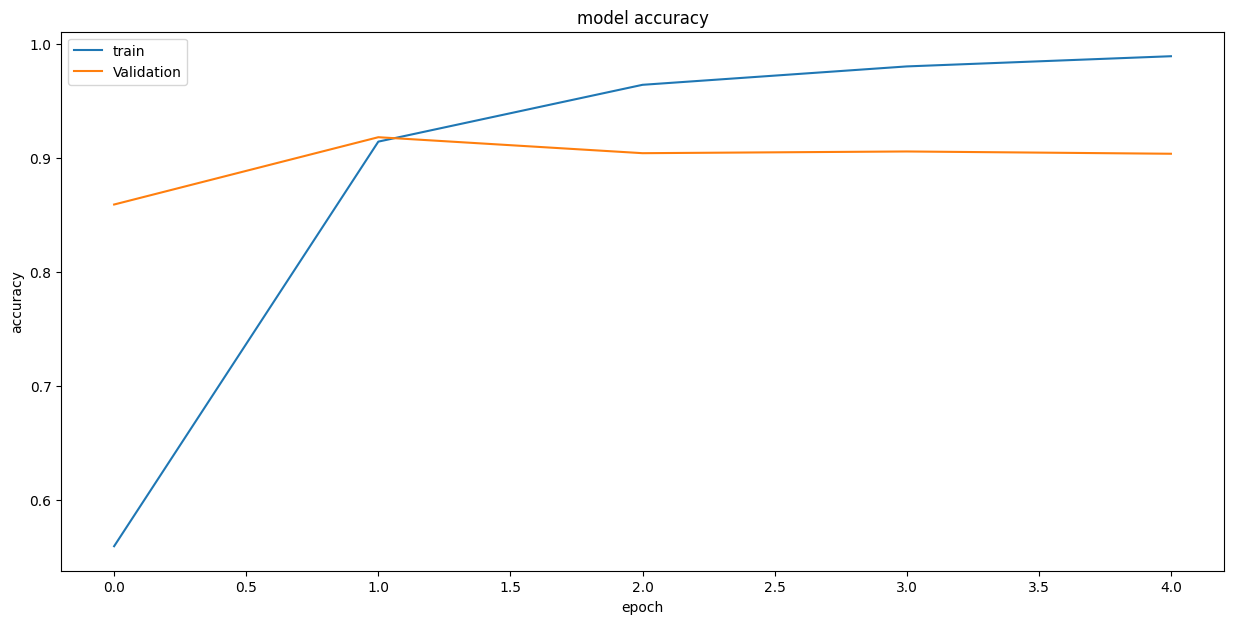

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

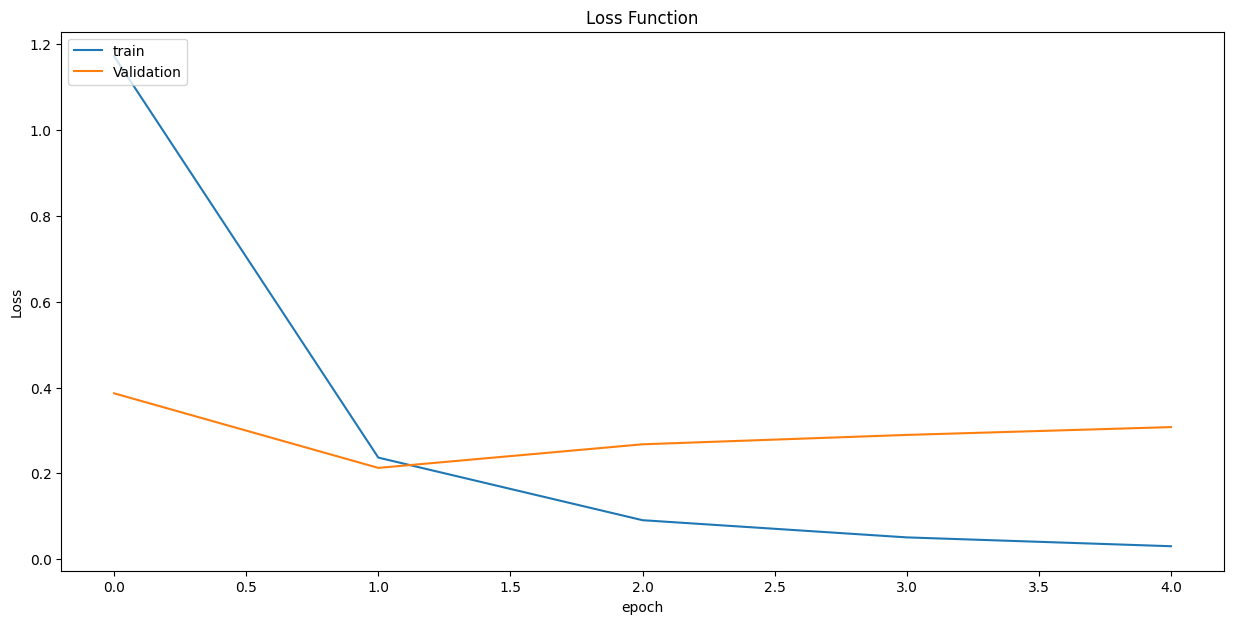

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 0s 26ms/step
joy : 0.746502697467804


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 0s 23ms/step
anger : 0.2557753324508667


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 0s 23ms/step
sadness : 0.9674819111824036


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 22ms/step
surprise : 0.9357088208198547




In [ ]:
import pickle
with open('tokenizer-cnn-lstm.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder-cnn-lstm.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion-Detection-cnn-lstm.h5')